# Mall Customer Segmentation

## Objective
Segment customers by **Age**, **Annual Income (k$)**, and **Spending Score (1–100)** to personalize marketing and tenant outreach using **unsupervised machine learning**.

---

## Project Summary
- **Dataset:** ~200 customers; features include Age, Annual Income, Spending Score, (Gender for profiling only).
- **Preprocessing:** verified ID uniqueness, encoded Gender (0/1), visualized univariate/bivariate distributions, **scaled** features for clustering.
- **Feature choice for training:** **Income × Spending**.
- **Model selection:** Elbow + Silhouette; compared **K-Means** and **Agglomerative (Ward)**.
- **Final model:** **K-Means, k = 5** on scaled Income × Spending  
  - Silhouette ≈ **0.56**; hierarchical clustering confirms similar structure.
- **Deliverables:** cluster profiles (means/SDs), business names for segments, actionable marketing recommendations, and cluster visualizations (Income vs. Spending with centroids).

---

## Workflow
1. **EDA:** distributions; Income/Spending vs. Gender/Age (original units).
2. **Scaling:** MinMaxScaler (0–1) for model fitting.
3. **Modeling:** Elbow (WCSS), Silhouette sweep; pick k; fit K-Means; validate with Hierarchical + dendrogram.
4. **Interpretation:** add labels to original data, compute per-cluster stats; name segments.
5. **Visualization:** scatter (Income vs. Spending) colored by cluster with centroids & labels.
6. **Recommendations:** targeted tactics per segment.

---

## Reproducibility
- Set `random_state=42`, `n_init=50` for K-Means.
- Train on the **scaled** matrix; analyze on the **original** DataFrame.
- Notebook sections are ordered to run top-to-bottom.

> **Output:** five clear customer segments (e.g., *Affluent Enthusiasts*, *Frugal Professionals*, *Steady Shoppers*, etc.) with practical marketing actions for each.



In [282]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Part 1: Exploratory Data Analysis (EDA) and Preprocessing

## 1.1. Data Loading and Initial Inspection

In [234]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [12]:
df.shape

(200, 5)

In [14]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [19]:
df['CustomerID'].nunique()

200

In [13]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


- The dataset contains 200 rows and 5 columns. There is no missing value. Among the 5 columns ('CustomerID', 'Gender', 'Age', 'Annual Income (k$)' and 'Spending Score (1-100)'), 'CustomerID' has 200 unique values which means it is unique for each customer.
- The other 4 columns can serve as features to divide customers into segments.

## 1.2. Feature Engineering and Transformation

### 1.2.1 Handle Categorical Data

In [235]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)
X_ohe = ohe.fit_transform(df[['Gender']])
ohe_cols = ohe.get_feature_names_out(['Gender'])
df_ohe = pd.DataFrame(X_ohe, columns=ohe_cols, index=df.index)
df_ohe.columns = ['Gender_is_male']
df_encoded = pd.concat([df.drop(columns=['Gender']), df_ohe], axis=1)


In [236]:
df_encoded.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male
0,1,19,15,39,1.0
1,2,21,15,81,1.0
2,3,20,16,6,0.0
3,4,23,16,77,0.0
4,5,31,17,40,0.0


### 1.2.2. Feature Selection

In [237]:
features = list(df_encoded.columns)
features.remove('CustomerID')
print(features)

['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_is_male']


- CustomerID is dropped and the rest of the columns are kept as features as shown above.

In [238]:
X = df_encoded[features]
X.shape

(200, 4)

### 1.2.3. Scaling/Normalization

In [239]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = df_encoded.copy()
df_scaled[features] = X_scaled

In [240]:
df_scaled.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male
0,1,0.019231,0.000000,0.387755,1.0
1,2,0.057692,0.000000,0.816327,1.0
2,3,0.038462,0.008197,0.051020,0.0
3,4,0.096154,0.008197,0.775510,0.0
4,5,0.250000,0.016393,0.397959,0.0


### 1.2.4. Why Scaling Is Necessary in K-Means (and Other Distance-Based Algorithms)

K-Means and other distance-based clustering algorithms (such as hierarchical clustering and DBSCAN) rely on measuring **distances** between data points — typically using the Euclidean distance formula:

$$
d(p, q) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \dots + (x_n - y_n)^2}
$$

Since this distance depends directly on the **magnitude** of feature values, variables with larger numeric ranges dominate the distance computation.  
For example, if *Annual Income (k$)* ranges from 15 to 137 while *Age* ranges only from 18 to 70, and *Gender* is encoded as 0 or 1, the income feature will vary by over 120 units, age by about 50, and gender by just 1.
As a result, the clustering process will be driven mainly by income, while age and gender although being potentially important will contribute very little to the overall distance calculation. To ensure that all features contribute equally to the clustering process, it is essential to **scale or normalize** the data so that each feature is on a comparable scale.

Two common approaches are:

- **Standardization (StandardScaler):**

  $$
  z = \frac{x - \mu}{\sigma}
  $$

  This transforms each feature to have a mean of 0 and a standard deviation of 1.  
  It is useful when features are approximately normally distributed.

- **Normalization (MinMaxScaler):**

  $$
  x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
  $$

  This rescales features to a fixed range, typically [0, 1], and is suitable when features have very different ranges or are not normally distributed.

Without scaling, K-Means tends to produce **biased clusters** dominated by high-magnitude features.  
With proper scaling, the algorithm measures distances fairly across all dimensions, allowing it to identify more **balanced and meaningful clusters**.


## 1.3. Univariate and Bivariate Analysis

### 1.3.1. visualize the distribution of Gender, Age, Annual Income and spending score among customers

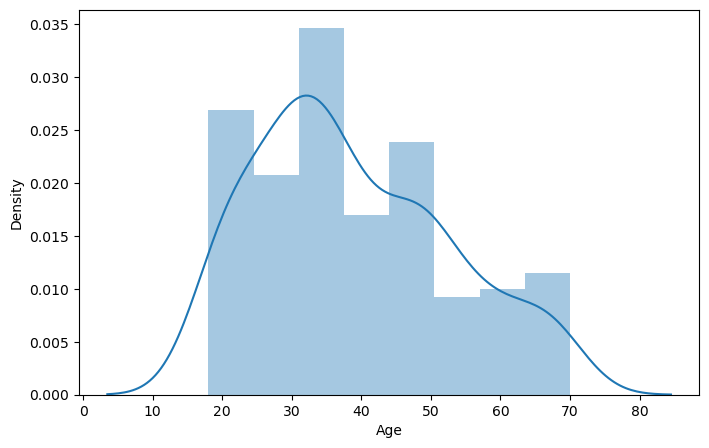

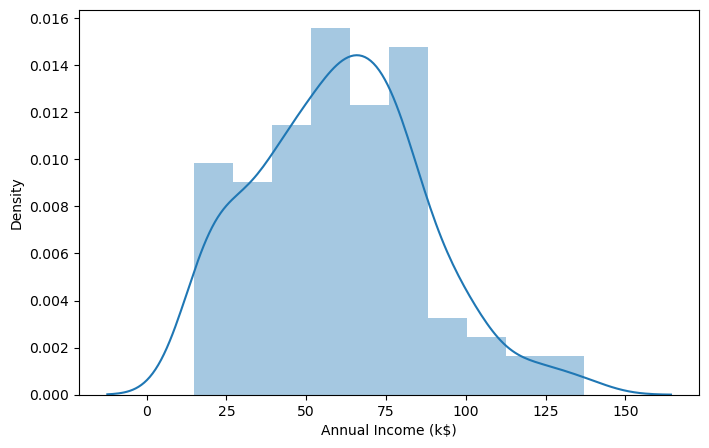

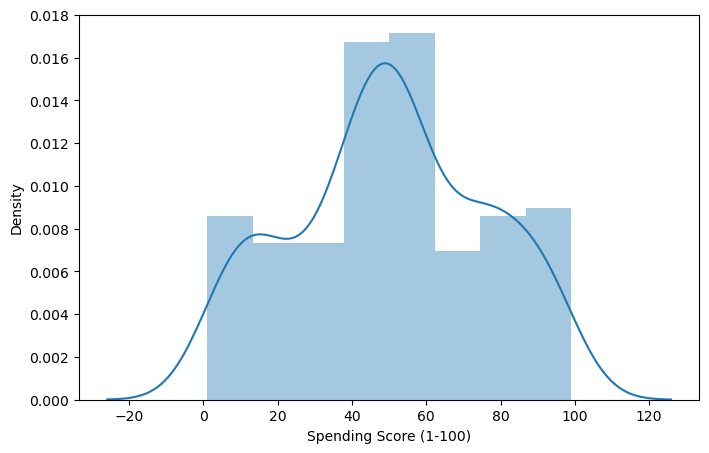

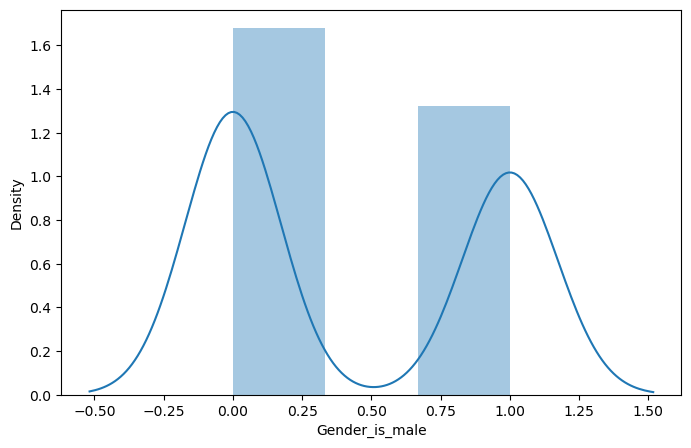

In [102]:
for i in features:
    plt.figure(figsize=(8,5))
    sns.distplot(df_encoded[i])

- ### Univariate Distribution Analysis

**Age**  
The age distribution appears roughly uniform to slightly right-skewed, suggesting a broad range of customer ages with more customers between 25–50 years old.

**Annual Income** 
Annual income shows a near-normal distribution centered around 60–80 k$, indicating most customers fall in the middle-income range.

**Spending Score (1–100)** 
The spending score distribution shows three distinct peaks, suggesting the presence of three customer groups: low spenders, moderate spenders, and high spenders.

**Gender_is_male**
Gender is binary with a slightly higher peak at 0 than 1, indicating a relatively even split between male and female customers, with a small majority of female customers.

### 1.3.2. Visualize the relationships between the features

- ### Distribution of Age, Annual Income and Spending Score by Gender

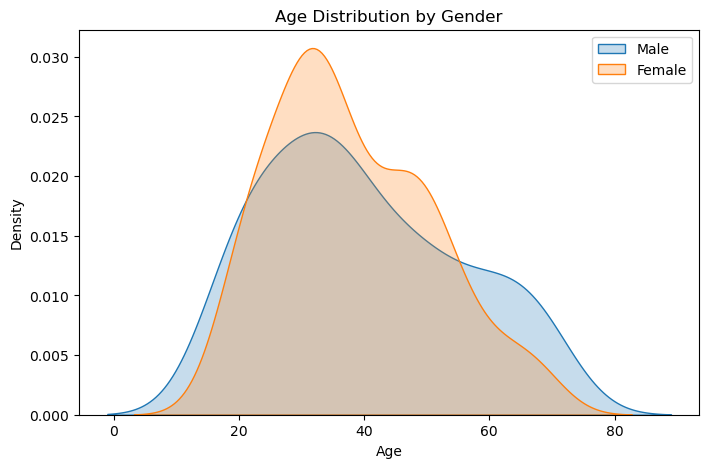

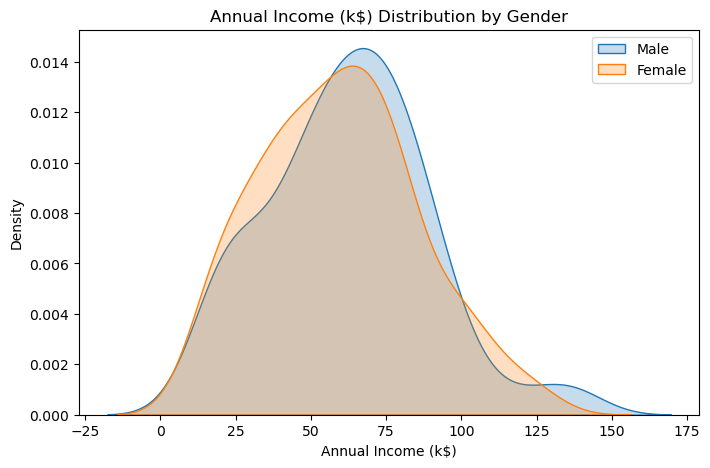

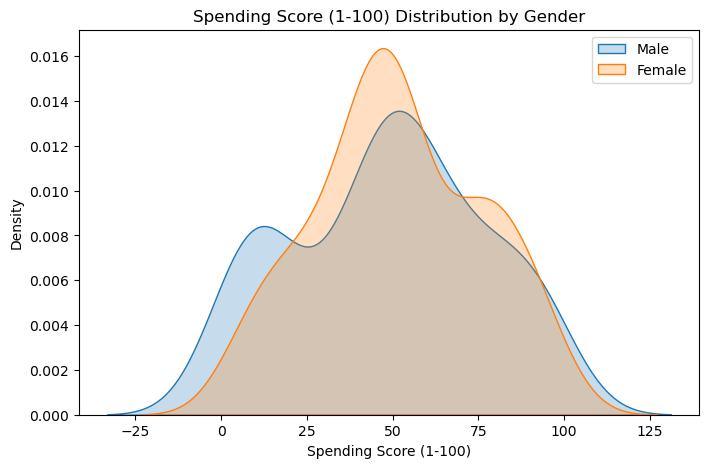

In [70]:
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for j in columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[df['Gender'] == 'Male'][j], shade=True, label="Male")
    sns.kdeplot(df[df['Gender'] == 'Female'][j], shade=True, label="Female")

    plt.xlabel(j)  # Dynamically set x-axis label
    plt.ylabel("Density")
    plt.title(f"{j} Distribution by Gender")  # Dynamic title
    plt.legend()
    plt.show()

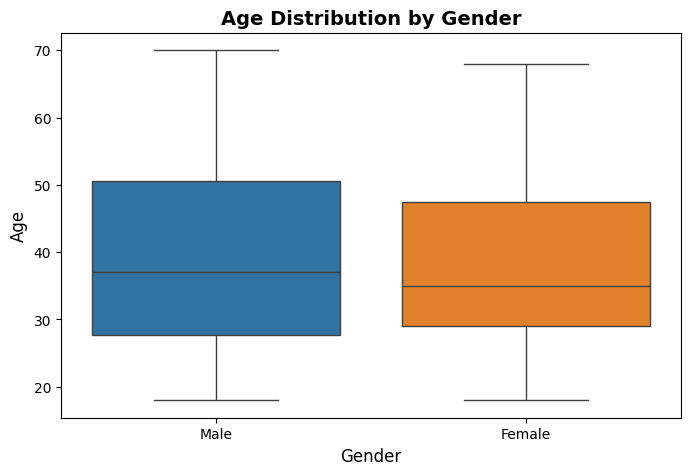

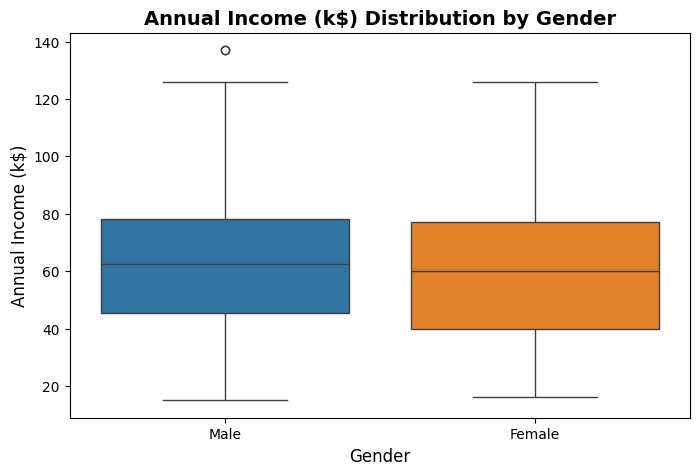

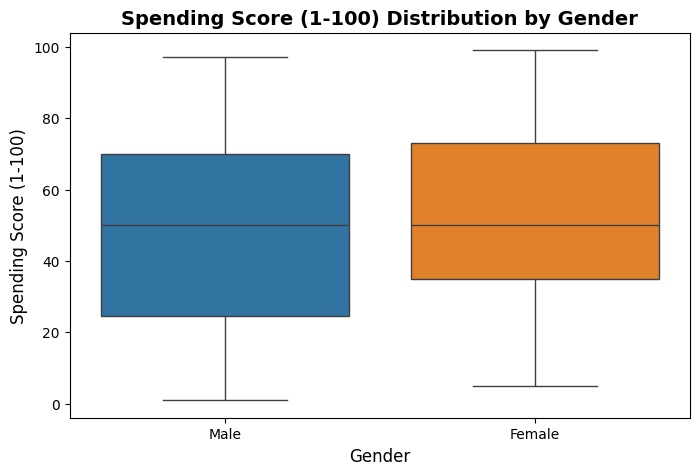

In [18]:
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Define colors for Male and Female
palette_colors = {"Male": "#1f77b4", "Female": "#ff7f0e"}

# Define columns to visualize
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for k in columns:
    plt.figure(figsize=(8, 5))
    
    # Create the boxplot with custom colors
    sns.boxplot(data=df, x='Gender', y=k, palette=palette_colors)
    
    # Dynamically set labels and title
    plt.xlabel("Gender", fontsize=12)
    plt.ylabel(k, fontsize=12)
    plt.title(f"{k} Distribution by Gender", fontsize=14, fontweight="bold")
    # Show the plot
    plt.show()


In [19]:
df['Gender'].value_counts(normalize=True)

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

- ### Bivariate Analysis: Age, Income, and Spending by Gender.

**Age vs. Gender**

Center: Females skew slightly younger; males have a marginally higher median.

Spread/Tails: Male ages are more dispersed with a longer right tail (more older males).

Takeaway: Large overlap—age differences by gender are modest.

**Annual Income vs. Gender**

Center: Males show a slightly higher median/mean income.

Spread/Tails: Males have a heavier right tail and a few higher-income outliers; females are more concentrated around ~40–80k.

Takeaway: Differences exist but are small; distributions largely overlap.

**Spending Score vs. Gender**

Shape: Both are multimodal; females peak a bit higher around mid–high scores (~50–80).

Center/Spread: Medians are similar (~50), but females have a higher lower quartile indicating fewer very-low spenders among females.

Takeaway: Gender explains little of spending on its own; other features likely drive segmentation.

### 1.3.3 Bivariate Analysis using Scatter Plots

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

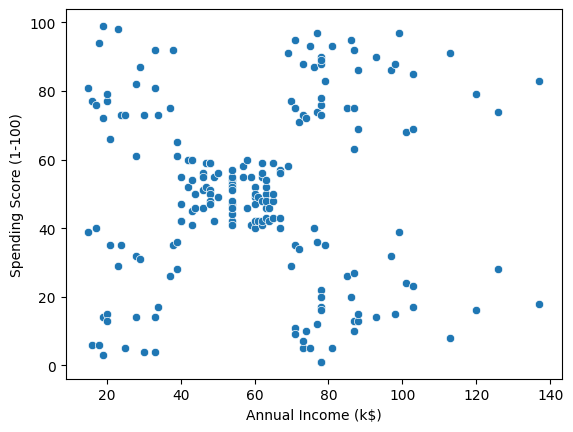

In [20]:
sns.scatterplot(df, x='Annual Income (k$)',y='Spending Score (1-100)' )

The scatter plot suggests the presence of clusters or groups of individuals with similar income and spending characteristics:

* A  cluster of individuals with low income and low spending scores.

* A cluster of individuals with high income and high spending scores.

* A cluster of individuals with moderate income and moderate spending scores.

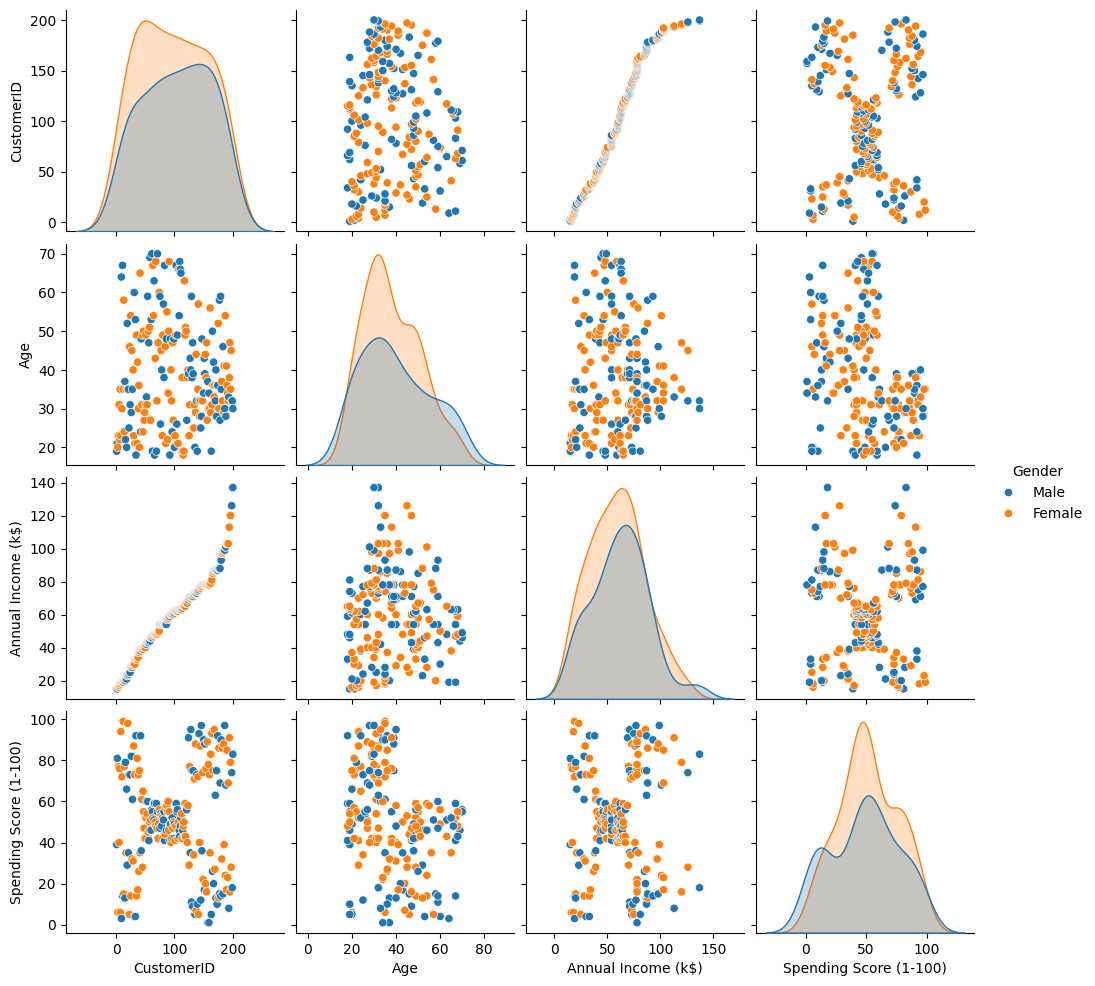

In [21]:
sns.pairplot(df,hue='Gender')


 It visualizes the pairwise relationships between numerical variables in the dataset while also differentiating the data points based on the 'Gender' column using color coding (blue for Male and orange for Female)

In [22]:
df.groupby('Gender')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


In [23]:
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()


,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000



Each value in the matrix represents the correlation coefficient (r) between the corresponding pair of variables. 
### Insight
* Younger customers tend to spend more, as shown by the negative correlation between Age and Spending Score.
* Income does not strongly influence spending habits, meaning high-income customers do not necessarily spend more.
* Age and income are weakly related, meaning income levels are relatively stable across different age groups.

<Axes: >

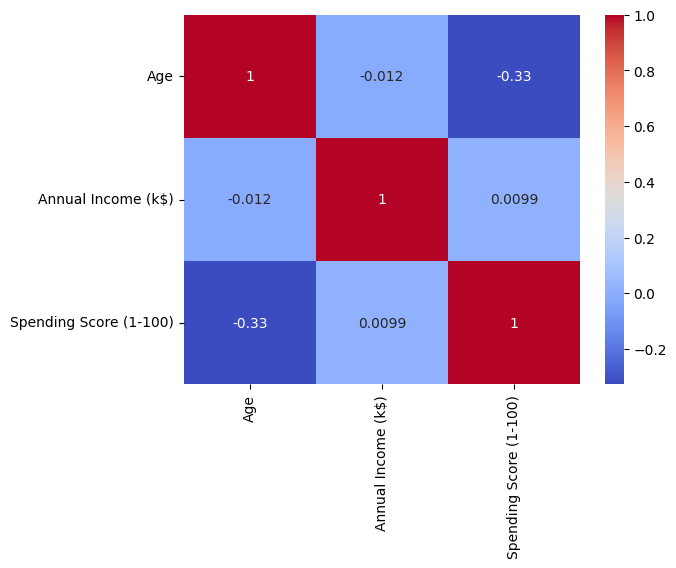

In [24]:
sns.heatmap(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr() ,annot=True,cmap='coolwarm')

# Part2 Clustering - Customer Segamentation


## 2.1. K-Means Clustering

### 2.1.1 Run K-Means with all four features

In [241]:
# computing the inertia score for different values of i (number of clusters) 
# The goal is to determine the optimal number of clusters (k) using the Elbow Method.

inertia_score = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init=50, random_state=42)
    kmeans.fit(df_scaled[features])
    inertia_score.append(kmeans.inertia_)

inertia_score

[86.68148216035945,
 37.27227241211876,
 29.552857611943857,
 22.39096001192855,
 19.05733326166018,
 16.41373703097379,
 14.210424128609382,
 12.243825066854683,
 10.57604374510544,
 9.40389112855273]

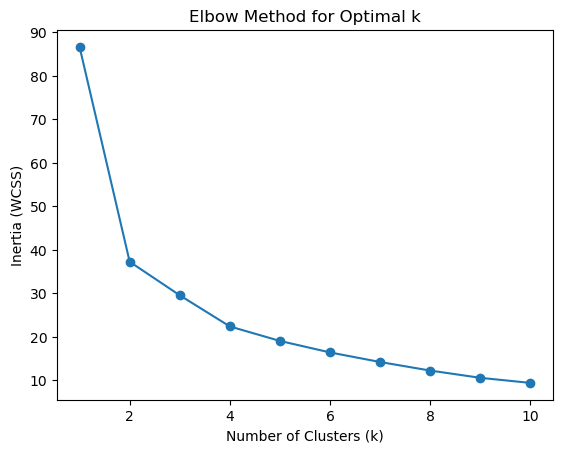

In [242]:
#Finding the Optimal k using the Elbow Method
plt.plot(range(1, 11), inertia_score, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

- ### The elbow point is 2, indicating the optimal number of clusters(=2).

In [243]:
# calculate silhouette score with k clusters to determine the best k

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    label = km.fit_predict(df_scaled[features])
    sil = silhouette_score(df_scaled[features], label)
    print(f"Silhouette Score with {k} clusters: {sil}")
    

Silhouette Score with 2 clusters: 0.5194624832665107
Silhouette Score with 3 clusters: 0.4583525581125425
Silhouette Score with 4 clusters: 0.36416575223390624
Silhouette Score with 5 clusters: 0.37073434917008075
Silhouette Score with 6 clusters: 0.37896616979430175
Silhouette Score with 7 clusters: 0.3842996892949768
Silhouette Score with 8 clusters: 0.3951934077579348
Silhouette Score with 9 clusters: 0.417141326209345
Silhouette Score with 10 clusters: 0.4323726547377212


- Both the elbow point and silhouette score show the best number of clusters is 2.

In [244]:
# Fitting the Model to the Data
# divide the data into three distinct groups based on similarities in Age, Gender, Annual Income and Spending Score.
km = KMeans(n_clusters=2, n_init=50, random_state=42)
label = km.fit_predict(df_scaled[features])
sil = silhouette_score(df_scaled[features], label)
print("Silhouette Score: ", sil)

Silhouette Score:  0.5194624832665107


In [201]:
# Extracting Cluster Labels
label

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0], dtype=int32)

In [202]:
# Storing Cluster Labels in the DataFrame
df_encoded['Cluster'] = label
df_encoded.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male,Cluster
0,1,19,15,39,1.0,0
1,2,21,15,81,1.0,0
2,3,20,16,6,0.0,1
3,4,23,16,77,0.0,1
4,5,31,17,40,0.0,1


Each row gets assigned a cluster number (0 or 1), grouping customers based on their Age, Annual Income, Gender and Spending Score.

In [203]:
df_encoded['Cluster'].value_counts()


Cluster
1    112
0     88
Name: count, dtype: int64

In [204]:
km.inertia_

37.27227241211876

In [205]:
df_encoded.columns

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_is_male', 'Cluster'],
      dtype='object')

In [206]:
df_encoded.groupby('Cluster')[['Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Gender_is_male']].mean()

,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male
Cluster,,,,
0,39.806818,62.227273,48.511364,1.0
1,38.098214,59.250000,51.526786,0.0


#### Insights from the Clusters
* The data was splitted almost perfectly by gender.
* Age and income are very similar across clusters, and spending differs only a few points (~3).
* The strong silhouette for k=2 is likely driven by this binary gender separation, not by a materially different customer profile.

### 2.1.2 Re-run K-Means without Gender and Age

In [255]:
inertia_score = []
features2 = ['Annual Income (k$)', 'Spending Score (1-100)']
df_2features = df_scaled[features2]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init=50, random_state=42)
    kmeans.fit(df_2features)
    inertia_score.append(kmeans.inertia_)

inertia_score

[23.040720326039906,
 13.993505283127975,
 9.058985215159455,
 6.110312266413656,
 3.5831179059525606,
 3.098385141882586,
 2.624103948396721,
 2.2168818321158827,
 1.879329153968098,
 1.6412663266849237]

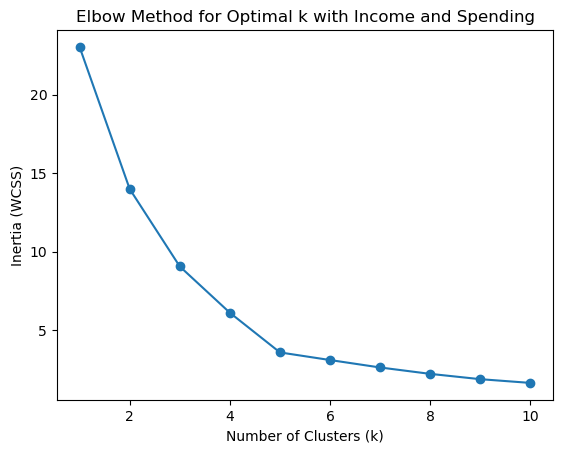

In [256]:
plt.plot(range(1, 11), inertia_score, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k with Income and Spending')
plt.show()

In [257]:
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    label = km.fit_predict(df_2features)
    sil = silhouette_score(df_2features, label)
    print(f"Silhouette Score with {k} clusters: {sil}")
    

Silhouette Score with 2 clusters: 0.33340205479864793
Silhouette Score with 3 clusters: 0.45149093095396503
Silhouette Score with 4 clusters: 0.4962007874638502
Silhouette Score with 5 clusters: 0.559485453135784
Silhouette Score with 6 clusters: 0.5377658513133247
Silhouette Score with 7 clusters: 0.5187916611945641
Silhouette Score with 8 clusters: 0.43119761928801525
Silhouette Score with 9 clusters: 0.44307967336659543
Silhouette Score with 10 clusters: 0.44597387106148084


- The elbow plot shows the best candidate is 5.
- The silhouette score confirms 5 is the best number of clusters.

In [259]:
# k = 5 clusters
km = KMeans(n_clusters=5, n_init=50, random_state=42)
label_2features = km.fit_predict(df_2features)
sil = silhouette_score(df_2features, label_2features)
print("Silhouette Score (5 groups): ", sil)

Silhouette Score (5 groups):  0.559485453135784


In [261]:
df_encoded.drop(columns = 'Cluster', inplace = True)
df_encoded.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male
0,1,19,15,39,1.0
1,2,21,15,81,1.0
2,3,20,16,6,0.0
3,4,23,16,77,0.0
4,5,31,17,40,0.0


In [262]:
df_encoded['Cluster'] = label_2features
df_encoded.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male,Cluster
0,1,19,15,39,1.0,4
1,2,21,15,81,1.0,0
2,3,20,16,6,0.0,4
3,4,23,16,77,0.0,0
4,5,31,17,40,0.0,4


In [263]:
df_encoded.groupby('Cluster')[['Age', 'Annual Income (k$)',
       'Spending Score (1-100)', 'Gender_is_male']].mean()

,Age,Annual Income (k$),Spending Score (1-100),Gender_is_male
Cluster,,,,
0,25.272727,25.727273,79.363636,0.409091
1,41.114286,88.200000,17.114286,0.542857
2,32.692308,86.538462,82.128205,0.461538
3,42.716049,55.296296,49.518519,0.407407
4,45.217391,26.304348,20.913043,0.391304


In [269]:
from sklearn.metrics import silhouette_samples
import numpy as np

sample_sil = silhouette_samples(df_2features.values, label_2features)
sizes = pd.Series(label_2features).value_counts().sort_index()
per_cluster_sil = pd.Series(sample_sil).groupby(label_2features).agg(['mean','median','min'])

print("Cluster sizes:\n", sizes)
print("\nPer-cluster silhouette:\n", per_cluster_sil.round(3))

# centroid distances (in scaled space)
centers = km.cluster_centers_
dists = np.sqrt(((centers[:, None, :] - centers[None, :, :])**2).sum(axis=2))
centroid_distances = pd.DataFrame(dists, index=range(km.n_clusters), columns=range(km.n_clusters))
print("\nCentroid distance matrix (scaled units):\n", centroid_distances.round(3))


Cluster sizes:
 0    22
1    35
2    39
3    81
4    23
Name: count, dtype: int64

Per-cluster silhouette:
     mean  median    min
0  0.586   0.646  0.038
1  0.510   0.552 -0.087
2  0.522   0.559  0.207
3  0.612   0.653  0.122
4  0.488   0.560 -0.045

Centroid distance matrix (scaled units):
        0      1      2      3      4
0  0.000  0.816  0.499  0.389  0.596
1  0.816  0.000  0.664  0.427  0.509
2  0.499  0.664  0.000  0.420  0.796
3  0.389  0.427  0.420  0.000  0.376
4  0.596  0.509  0.796  0.376  0.000


- k = 5 looks solid. All clusters are ≥ ~10% of n (22–81 pts), and per-cluster silhouettes are good (means ≈ 0.49–0.61). This is a coherent, interpretable segmentation.

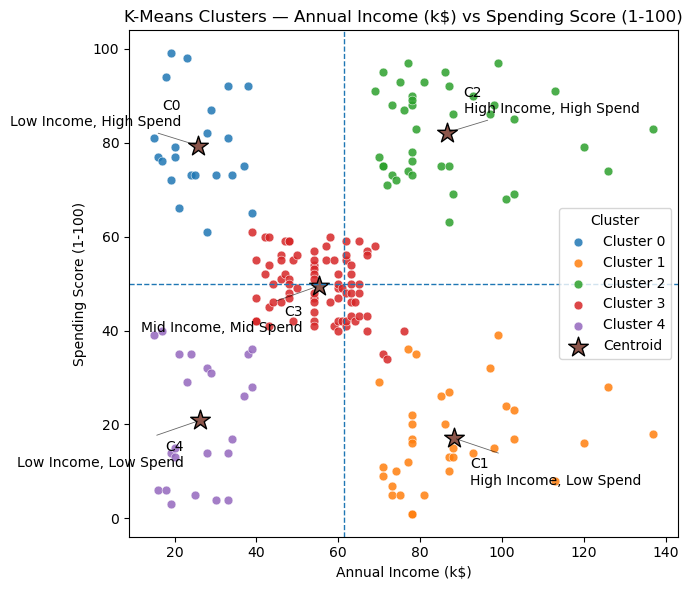

In [276]:
# Visualization

x_feat = 'Annual Income (k$)'
y_feat = 'Spending Score (1-100)'
try:
    ix = features2.index(x_feat)
    iy = features2.index(y_feat)
    centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)
    centers_df = pd.DataFrame(centers_orig, columns=features2)
    centers_xy = centers_df[[x_feat, y_feat]].assign(Cluster=np.arange(len(centers_df)))
except Exception:
    centers_xy = (df_encoded
                  .groupby('Cluster')[[x_feat, y_feat]]
                  .mean()
                  .reset_index())

x_med = df_encoded[x_feat].median()
y_med = df_encoded[y_feat].median()
x_lo, x_hi = df_encoded[x_feat].quantile([0.33, 0.67])
y_lo, y_hi = df_encoded[y_feat].quantile([0.33, 0.67])

def bucket3(v, lo, hi):
    if v < lo:   return 'Low'
    if v > hi:   return 'High'
    return 'Mid'

centers_xy['Tag'] = centers_xy.apply(
    lambda r: f"{bucket3(r[x_feat], x_lo, x_hi)} Income, {bucket3(r[y_feat], y_lo, y_hi)} Spend",
    axis=1
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(7,6))

# scatter points by cluster (default color cycle gives different colors)
for c in sorted(df_encoded['Cluster'].unique()):
    m = (df_encoded['Cluster'] == c)
    ax.scatter(df_encoded.loc[m, x_feat],
               df_encoded.loc[m, y_feat],
               s=40, alpha=0.85, edgecolor='w', linewidth=0.4,
               label=f'Cluster {c}')

# overlay centroids
ax.scatter(centers_xy[x_feat], centers_xy[y_feat],
           marker='*', s=220, edgecolor='black', linewidth=1.0, label='Centroid')

# annotate each centroid with Cluster ID + story tag
# Decide offsets by quadrant (relative to medians) so labels move away from the crosshair
offset_map = {
    (True,  True ): (12, 12),   # right & top  -> up-right
    (True,  False): (12,-14),   # right & bottom -> down-right
    (False, True ): (-12,12),   # left & top  -> up-left
    (False, False): (-12,-14)   # left & bottom -> down-left
}

for _, r in centers_xy.iterrows():
    right = r[x_feat] >= x_med
    top   = r[y_feat] >= y_med
    dx, dy = offset_map[(right, top)]

    ax.annotate(
        f"C{int(r['Cluster'])}\n{r['Tag']}",
        xy=(r[x_feat], r[y_feat]),          # centroid
        xytext=(dx, dy), textcoords='offset points',
        ha='left' if right else 'right',
        va='bottom' if top else 'top',
        arrowprops=dict(arrowstyle='-', lw=0.6, alpha=0.6),
        bbox=dict(boxstyle='round,pad=0.25', fc='none', ec='none', alpha=0.9)
    )

# median lines for reading quadrants
ax.axvline(x_med, linestyle='--', linewidth=1)
ax.axhline(y_med, linestyle='--', linewidth=1)

ax.set_title(f'K-Means Clusters — {x_feat} vs {y_feat}')
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title='Cluster', frameon=True)
plt.tight_layout()
plt.show()

## Cluster Insights (k = 5, trained on Income × Spending; Age/Gender for profiling)

### C0 — **Low-Income, High-Spend “Splurgers”**
- **Age:** ~25
- **Annual Income:** ~26k (low)
- **Spending Score:** ~79 (high)
- **Gender (male):** ~41%
- **Behavior:** Experience/impulse-driven despite tight budgets.
- **Tactics:** Buy Now Pay Later/installments, flash deals, social/creator promos.

### C1 — **Affluent, Low-Spend “Frugal Professionals”**
- **Age:** ~41
- **Annual Income:** ~88k (high)
- **Spending Score:** ~17 (very low)
- **Gender (male):** ~54%
- **Behavior:** Infrequent, purpose-led purchases; value/time sensitive.
- **Tactics:** Premium value messaging, warranties, express/curbside pickup.

### C2 — **Affluent, High-Spend “Enthusiasts”**
- **Age:** ~33
- **Annual Income:** ~87k (high)
- **Spending Score:** ~82 (very high)
- **Gender (male):** ~46%
- **Behavior:** Premium-oriented, high engagement and frequency.
- **Tactics:** VIP tiers, exclusives/early access, curated bundles.

### C3 — **Mid-Income, Mid-Spend “Steady Shoppers”**
- **Age:** ~43
- **Annual Income:** ~55k (medium)
- **Spending Score:** ~50 (moderate)
- **Gender (male):** ~41%
- **Behavior:** Routine baskets, responsive to targeted savings.
- **Tactics:** Coupons, bundles, replenish/subscription programs.

### C4 — **Low-Income, Low-Spend “Minimalists”**
- **Age:** ~45
- **Annual Income:** ~26k (low)
- **Spending Score:** ~21 (low)
- **Gender (male):** ~39%
- **Behavior:** Necessity/value-focused, low discretionary spend.
- **Tactics:** Everyday-low-price assortments, subscribe-and-save on staples.

---

### Takeaways
- Clear segmentation emerges along **Income × Spending**; **Age** refines personas but isn’t a driver.
- **Gender** remains ~balanced across clusters → appropriate to exclude from training.


## 2.2. Hierarchical Clustering 

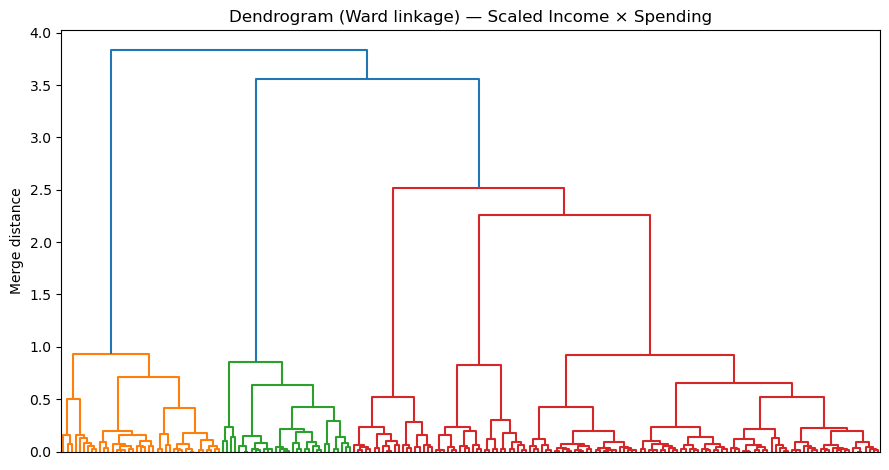

[HC] k=5, silhouette=0.558


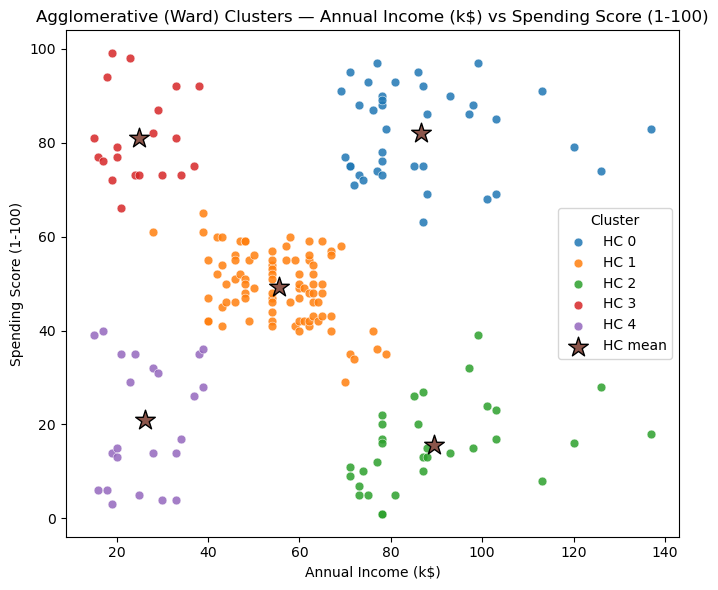

HC vs K-Means (row-normalized):


Cluster,0,1,2,3,4
HC_Cluster,,,,,
0,0.000,0.000,1.0,0.000,0.0
1,0.023,0.035,0.0,0.942,0.0
2,0.000,1.000,0.0,0.000,0.0
3,1.000,0.000,0.0,0.000,0.0
4,0.000,0.000,0.0,0.000,1.0


[K-Means] k=5, silhouette=0.559  |  [HC] 0.558


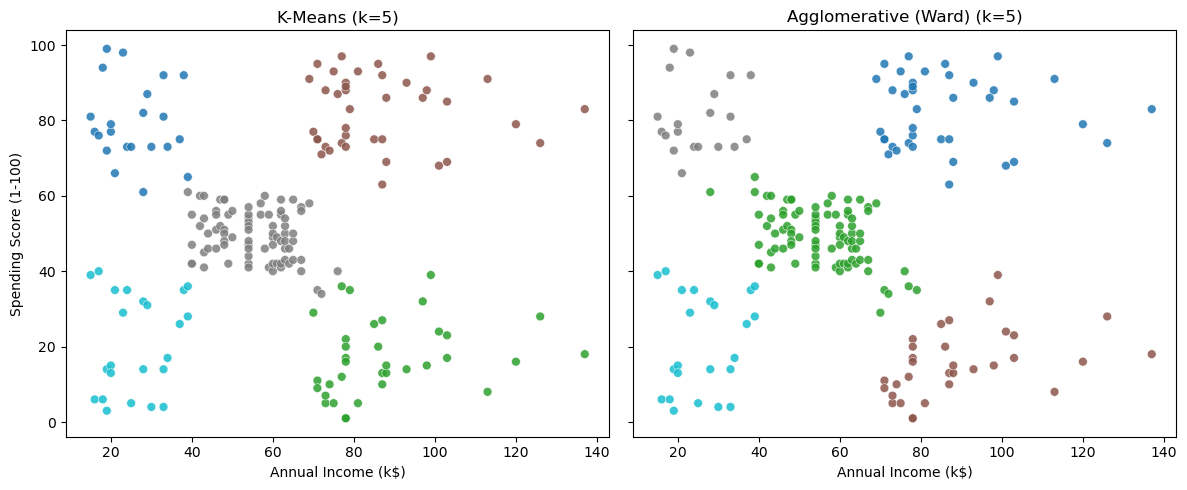

In [278]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# --- 0) Prepare data (use the same 2 features used for K-Means) ---
x_feat = 'Annual Income (k$)'
y_feat = 'Spending Score (1-100)'
features_hc = [x_feat, y_feat]  # training features

X_orig = df_encoded[features_hc].copy()
scaler_hc = MinMaxScaler().fit(X_orig)       # scale for dendrogram/HC
X_scaled_hc = scaler_hc.transform(X_orig)

# --- 1) Dendrogram (Ward linkage with Euclidean distance) ---
Z = sch.linkage(X_scaled_hc, method='ward')  # ward minimizes within-cluster variance

plt.figure(figsize=(9, 4.8))
sch.dendrogram(Z, no_labels=True, color_threshold=None)
plt.title('Dendrogram (Ward linkage) — Scaled Income × Spending')
plt.ylabel('Merge distance')
plt.tight_layout()
plt.show()

# draw a horizontal cut line to get ~k clusters (adjust 'h_cut' after viewing the plot)
h_cut = None  # e.g., 0.9
if h_cut is not None:
    plt.figure(figsize=(9, 4.8))
    sch.dendrogram(Z, no_labels=True, color_threshold=h_cut)
    plt.axhline(h_cut, ls='--', c='k', lw=1)
    plt.title(f'Dendrogram with cut at {h_cut}')
    plt.ylabel('Merge distance')
    plt.tight_layout()
    plt.show()

# --- 2) Choose k from dendrogram (set it after looking at the plot) ---
# From K-Means work, k=5 is a good, parsimonious choice; use that to compare apples-to-apples.
k_hc = 5

# --- 3) Agglomerative Clustering (Ward) ---
hc = AgglomerativeClustering(n_clusters=k_hc, linkage='ward')
labels_hc = hc.fit_predict(X_scaled_hc)

# Silhouette to assess HC vs K-Means (optional; requires K-Means labels to be present)
sil_hc = silhouette_score(X_scaled_hc, labels_hc)
print(f"[HC] k={k_hc}, silhouette={sil_hc:.3f}")

# Add HC labels back to original df for interpretation
df_hc = df_encoded.copy()
df_hc['HC_Cluster'] = labels_hc

# --- 4) Visualization: Income vs Spending colored by HC cluster ---
fig, ax = plt.subplots(figsize=(7, 6))
for c in sorted(df_hc['HC_Cluster'].unique()):
    m = df_hc['HC_Cluster'] == c
    ax.scatter(df_hc.loc[m, x_feat], df_hc.loc[m, y_feat],
               s=40, alpha=0.85, edgecolor='w', linewidth=0.4, label=f'HC {c}')

# Overlay HC "centers" as group means (hierarchical has no centroids)
means_hc = df_hc.groupby('HC_Cluster')[[x_feat, y_feat]].mean().sort_index()
ax.scatter(means_hc[x_feat], means_hc[y_feat],
           marker='*', s=220, edgecolor='k', linewidth=1.0, label='HC mean')

ax.set_title(f'Agglomerative (Ward) Clusters — {x_feat} vs {y_feat}')
ax.set_xlabel(x_feat); ax.set_ylabel(y_feat)
ax.legend(title='Cluster', frameon=True)
plt.tight_layout()
plt.show()

# --- 5) Side-by-side comparison with the existing K-Means labels ---
if 'Cluster' in df_encoded.columns:
    # Crosstab (how HC groups align with K-Means groups)
    comp = pd.crosstab(df_hc['HC_Cluster'], df_encoded['Cluster'], normalize='index').round(3)
    print("HC vs K-Means (row-normalized):")
    display(comp)

    # Compare silhouettes 
    from sklearn.cluster import KMeans
    km5 = KMeans(n_clusters=k_hc, n_init=50, random_state=42).fit(X_scaled_hc)
    sil_km5 = silhouette_score(X_scaled_hc, km5.labels_)
    print(f"[K-Means] k={k_hc}, silhouette={sil_km5:.3f}  |  [HC] {sil_hc:.3f}")

    # Plot K-Means vs HC for visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    # K-Means
    axes[0].scatter(X_orig[x_feat], X_orig[y_feat], c=km5.labels_, cmap='tab10',
                    s=40, alpha=0.85, edgecolor='w', linewidth=0.4)
    axes[0].set_title('K-Means (k=5)')
    axes[0].set_xlabel(x_feat); axes[0].set_ylabel(y_feat)
    # HC
    axes[1].scatter(X_orig[x_feat], X_orig[y_feat], c=labels_hc, cmap='tab10',
                    s=40, alpha=0.85, edgecolor='w', linewidth=0.4)
    axes[1].set_title('Agglomerative (Ward) (k=5)')
    axes[1].set_xlabel(x_feat)
    plt.tight_layout()
    plt.show()

## Insights HC and K-Means Comparison

- HC vs K-Means comparison shows they’re essentially the same segmentation.
- Silhouette: K-Means 0.559 vs. HC 0.558 indistinguishable quality.
- Alignment (crosstab): 4/5 HC clusters map 1.00 to a single K-Means cluster; the remaining HC cluster maps ~0.94 to its K-Means counterpart (tiny spillover).
- Plots: Cluster shapes/locations match; differences are only at boundaries (mid-income/mid-spend area).

# Part 3: Interpretation and Conclusion

# Interpretation & Conclusion (k = 5)

**Method recap.**  
We clustered customers using **K-Means** on **Income × Spending** (MinMax-scaled).  
Elbow suggested **k≈5–6**; **k=5** was chosen for parsimony. The 2-feature model scored **silhouette ≈ 0.56** and matched **Agglomerative (Ward)** almost exactly (same structure, similar silhouette).

---

## 1) Characterize the Clusters

> Means shown in original units; Age/Gender were **not** used for training, only for profiling.

| Cluster | Name | Size | Age (mean) | Income (k$, mean) | Spending (mean) | Male % | Quick profile |
|---:|---|---|---:|---:|---:|---:|---|
| **C0** | **Low-Income, High-Spend “Splurgers”** | 22 (11.0%) | 25.27 | 25.73 | **79.36** | 40.9% | Young, tight budgets, high discretionary spend. |
| **C1** | **High-Income, Low-Spend “Frugal Professionals”** | 35 (17.5%) | 41.11 | **88.20** | **17.11** | 54.3% | Affluent but infrequent/purpose-driven buyers. |
| **C2** | **High-Income, High-Spend “Enthusiasts”** | 39 (19.5%) | 32.69 | **86.54** | **82.13** | 46.2% | Premium-oriented, high engagement/frequency. |
| **C3** | **Mid-Income, Mid-Spend “Steady Shoppers”** | 81 (40.5%) | 42.72 | 55.30 | 49.52 | 40.7% | Large mainstream segment; predictable baskets. |
| **C4** | **Low-Income, Low-Spend “Minimalists”** | 23 (11.5%) | 45.22 | 26.30 | 20.91 | 39.1% | Necessity/value-led; low discretionary spend. |

---

## 2) Recommendations

### C0 — Low-Income, High-Spend “Splurgers”
- **Positioning:** experiential/impulse, trend-led.
- **Tactics:** BNPL/installments, flash deals, social/creator drops, limited-time bundles, mobile push.
- **KPIs:** conversion rate on promos, repeat rate after BNPL.

### C1 — High-Income, Low-Spend “Frugal Professionals”
- **Positioning:** quality, time-saving, peace-of-mind.
- **Tactics:** premium value messaging, warranties/guarantees, concierge/express pickup, targeted high-value coupons.
- **KPIs:** win-back frequency, AOV lift on targeted offers.

### C2 — High-Income, High-Spend “Enthusiasts”
- **Positioning:** exclusivity and curation.
- **Tactics:** VIP tiering, early access, personalized bundles, cross-sell premium categories, invite-only events.
- **KPIs:** loyalty tier penetration, cross-category attach rate.

### C3 — Mid-Income, Mid-Spend “Steady Shoppers”
- **Positioning:** reliable value and convenience.
- **Tactics:** subscribe-&-save, basket-based coupons, replenishment reminders, weekly offers.
- **KPIs:** basket size, subscription uptake, retention.

### C4 — Low-Income, Low-Spend “Minimalists”
- **Positioning:** essentials at trusted prices.
- **Tactics:** everyday-low-price assortments, staple bundles, price matching, community/senior-day offers.
- **KPIs:** visit frequency, staple penetration, price-sensitivity indices.

---

## Conclusion

- **Optimal k:** **5** clusters (Elbow ≈ 5–6; **silhouette ≈ 0.56**; HC agrees).  
- **Drivers:** Segmentation is primarily along **Income × Spending**; **Age** refines personas and **Gender** is balanced—appropriate to exclude both from training.  
- **Business insight:** We identify five actionable segments from **Affluent Enthusiasts** to **Minimalists**—with clear, distinct tactics. The largest opportunity pools are **C2 (high value)** and **C3 (broad base)**; **C0** merits promo-led monetization, while **C1** needs value-proof and convenience to unlock spend.

---

## Add Standard Deviations

```python
# Compute per-cluster means and stds in original units
stats = (df_encoded
         .groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']]
         .agg(['mean','std'])
         .round(2))
display(stats)


In [280]:
df_encoded.to_csv('Clustering.csv')
